In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
from PIL import Image
import cv2


In [2]:
SEED = 22

np.random.seed(SEED)

In [38]:
#organizing the dataframe to contain filepath and diagnosis

train_filepath = 'data/train_images/'
test_filepath = 'data/test_images/'

df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

train_X = df_train['id_code'].values
train_y = df_train['diagnosis'].values

#image list is the list of image filepaths in order
image_list = list(map((lambda fi: train_filepath+fi), os.listdir(train_filepath)))

print('train data size: ',train_y.shape)
print('train file name: ', os.listdir(train_filepath)[0])

tofileloc = lambda fi: train_filepath + fi + '.png'

df_train['id_code'] = df_train['id_code'].apply(tofileloc)
df_train = df_train.rename(index=str, columns={'id_code': 'filepath'})

print(df_train.head())


train data size:  (3662,)
train file name:  91a88d3b0358.png
                             filepath  diagnosis
0  data/train_images/000c1434d8d7.png          2
1  data/train_images/001639a390f0.png          4
2  data/train_images/0024cdab0c1e.png          1
3  data/train_images/002c21358ce6.png          0
4  data/train_images/005b95c28852.png          0


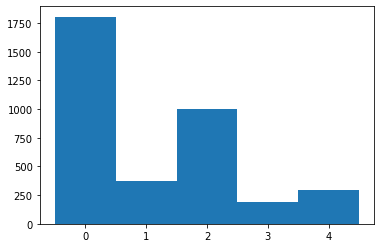

In [46]:
#plotting the count for each level of diagnosis
diagnoses = np.unique(train_y)
diagnosis_indices = []
for diag in diagnoses:
    diagnosis_indices.append(np.arange(df_train.shape[0])[df_train['diagnosis'] == diagnoses[diag]])
    
hist = plt.hist(train_y, bins=np.linspace(-.5,4.5,6))

In [103]:
# making a matrix of indices for  aset of test images
# 5,5 matrix with 5 images from each diagnosis
img_subset = np.zeros((5,5))

for diag in diagnoses:
    img_idx = np.random.choice(diagnosis_indices[diag], size=5)
    img_subset[diag,:] = img_idx

print(img_subset)

getlabels = np.vectorize(lambda row: df_train['diagnosis'].values[row])

img_subset = img_subset.astype(int)
img_subset_arr = img_subset.reshape((1,-1)).astype(int)
print( 'diagnoses: \n', np.asarray([getlabels(xi) for xi in img_subset_arr]).reshape((5,5)))

[[  96. 2478. 2965.   18.  782.]
 [ 331.  481.  331. 1881. 1881.]
 [3123. 1408. 2022.  245. 3595.]
 [3546.  343. 2077. 1390. 1551.]
 [ 660. 1384.  561. 1078. 1763.]]
diagnoses: 
 [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]


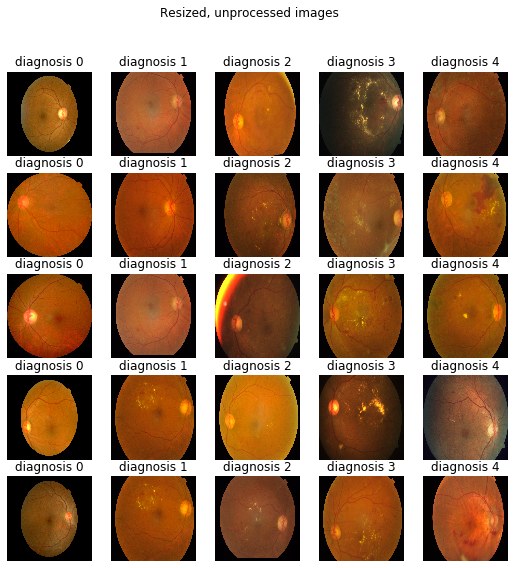

In [110]:
IMAGE_SIZE = (500, 500)
#selecting 5 random images from each diagnosis to plot in a grid

f, ax = plt.subplots(5,5, figsize = (9,9))
for i in range(5):
    
    for j in range(5):

        pil_img = Image.open(df_train['filepath'].values[img_subset[i,j]])
        pil_img = pil_img.resize(IMAGE_SIZE)
        
        ax[j, i].imshow(pil_img)
        ax[j, i].axis('off')
        ax[j, i].set_title('diagnosis ' + str(i))
        
f.suptitle('Resized, unprocessed images')
plt.show()


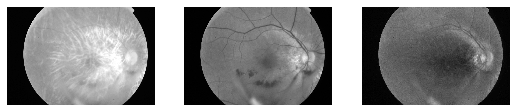

In [195]:
pil_img = Image.open(df_train['filepath'].values[img_subset[4,4]])
np_img = np.array(pil_img)

R_img = np_img[...,0]
G_img = np_img[...,1]
B_img = np_img[...,2]

R_img = Image.fromarray(R_img)
G_img = Image.fromarray(G_img)
B_img = Image.fromarray(B_img)

f, ax = plt.subplots(1,3, figsize=(9,9))

_=ax[0].imshow(R_img, cmap='gray'); _=ax[0].axis('off')
_=ax[1].imshow(G_img, cmap='gray'); _=ax[1].axis('off')
_=ax[2].imshow(B_img, cmap='gray'); _=ax[2].axis('off')



In [255]:
# start processing images by cropping down the black space around the outsides
# this process should remove and black rows/ columns on the top/bottom/sides
# of every image

def crop_image(np_img, tol=None):
    
    if tol == None:
        tol = (np.max(np_img)/255)*10
    
    # crop left columns
    while np.mean(np.sum(np_img[:,0,:], axis=1)) < tol:
        np_img = np.delete(np_img, 0, 1) # deleting the 0th column (axis=1)
    
    # crop right columns
    while np.mean(np.sum(np_img[:,-1,:], axis=1)) < tol:
        np_img = np.delete(np_img, -1, 1)
        
    # crop top rows
    while np.mean(np.sum(np_img[0,:,:], axis=1)) < tol:
        np_img = np.delete(np_img, 0, 0)
    
    # crop bottom rows
    while np.mean(np.sum(np_img[-1,:,:], axis=1)) < tol:
        np_img = np.delete(np_img, -1, 0)
    
    return np_img

def rgb2gray(np_img):
    # unfinished function to return a single channel image in grayscale
    m,n,n_channels = np_img.shape
    
    assert (n_channels == 3), "Must have 3 channels for RGB"
    R = np_img[:,:,0] * .2989
    G = np_img[:,:,1] * .5870
    B = np_img[:,:,2] * .1140
    
    img_out = np.add(np.add(R,G),B)
    img_out = np_img[:,:,1]
    
    return img_out
    
    
def gauss_kernel(sigma=1, dim=5):
    # gaussian filter to remove noise  
    g_kernel = np.zeros((dim,dim))
    center = ((dim-1)/2, (dim-1)/2)
    gauss_dist = lambda d: np.exp(-(np.power(d,2))/sigma)
    
    for i in range(dim):
        for j in range(dim):
            dist = np.sqrt(np.power(i-center[0], 2) + np.power(j-center[0], 2))
            g_kernel[i,j] = gauss_dist(dist)
    
    g_kernel = g_kernel/np.sum(g_kernel)
    
    return g_kernel

def laplacian_kernel(dim=5):
    l_kernel = np.ones((dim,dim))
    center = int(np.floor((dim-1)/2))
    
    if dim%2==0:
        sub = -((dim**2)/4)+1
        l_kernel[center, center] = sub
        l_kernel[center+1, center] = sub
        l_kernel[center, center+1] = sub
        l_kernel[center+1, center+1] = sub
        
    else: 
        sub = -(dim**2)+1
        l_kernel[center, center] = sub
        
    return l_kernel
        
            
            
def apply_filter(np_img, kernel):
    
    assert kernel.shape[0] == kernel.shape[1], "kernel must be 2d square matrix"
    
    img_out = cv2.filter2D(np_img, -1, kernel)
    
    return img_out
        
    
def round_(x, tol=10):
    if x>tol:
        return 255
    else:
        return 0
    
round_mat = np.vectorize(round_)



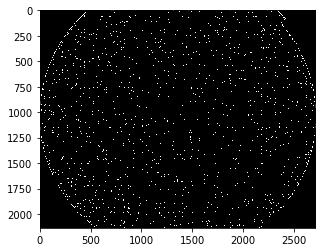

In [257]:
np_cropped_img = crop_image(np_img)
cropped_img = Image.fromarray(np_cropped_img)

np_gray_cropped_img = rgb2gray(np_cropped_img)
gray_cropped_img = Image.fromarray(np_gray_cropped_img)

#kernel = gauss_kernel(sigma=15, dim=105)
kernel = laplacian_kernel()
np_filtered_img = apply_filter(np_gray_cropped_img, kernel) 
np_rounded_filtered_img = round_mat(np_filtered_img, tol=50).astype(np.uint8)


filtered_img = Image.fromarray(np_rounded_filtered_img)
plt.imshow(filtered_img, cmap='gray')

In [222]:
# tyring different clustering methods to detect objects on the images

In [258]:
# test random stuff
test_arr = np.arange(9).reshape((3,3))

test_rounded = round_mat(test_arr, 5)
test_rounded = test_rounded.astype(np.uint8)
print(test_rounded)

[[  0   0   0]
 [  0   0   0]
 [255 255 255]]


In [253]:
test_int = np.array([200])
test_int = test_int.astype(np.uint8)
print(test_int)

[200]
